In [1]:
import os
import pickle
from importlib import reload

import torch
import numpy as np
import pandas as pd
import sciplots as plots
import netloader.networks as nets
from scipy import stats
from sklearn.decomposition import PCA
from netloader.data import loader_init
from sciplots.utils import label_change

from src import main
from src.utils import data
from src.utils import analysis, plot_config
from src.utils.utils import open_config, overlap, ROOT

reload(plots.base)
reload(plots.single_plots)
reload(plots)
reload(data)
reload(analysis)
reload(main)

import sciplots as plots
from src.utils import analysis
from src.utils.data import DarkDataset

In [2]:
def merge_plots(plot_base, plot_append):
    plot_base._y_data = list(plot_base._y_data) if isinstance(plot_base._y_data, np.ndarray) else plot_base._y_data

    for line, poly in zip(plot_append.plots[plot_append.axes][::2], plot_append.plots[plot_append.axes][1::2]):
        line.remove()
        poly.remove()
        plot_append.plots[plot_append.axes].remove(line)
        plot_append.plots[plot_append.axes].remove(poly)

        line.set_ydata(line.get_ydata() / np.trapezoid(line.get_ydata(), np.log10(line.get_xdata())))
        verts = poly.get_paths()[0].vertices
        verts[:, 1] = verts[:, 1] / np.sum(verts[:, 1])
        poly.set_verts([verts])

        plot_append.axes.add_line(line)
        plot_append.axes.add_collection(poly)
        plot_append.plots[plot_append.axes].append(line)
        plot_append.plots[plot_append.axes].append(poly)

    for line in plot_append.plots[plot_append.axes][::2]:
        plot_base.plots[plot_base.axes].append(
            plot_base.axes.plot(*line.get_xydata().swapaxes(0, 1), color=line.get_color(), alpha=0.4, ls='-')[0])
        plot_base._data.append(line.get_xdata())
        plot_base._y_data.append(line.get_ydata())

    plot_base.axes.set_xlim(min([min(datum[y_datum > 1e-4]) for datum, y_datum in zip(plot_base._data, plot_base._y_data)]),
                            max([max(datum[y_datum > 1e-4]) for datum, y_datum in zip(plot_base._data, plot_base._y_data)]))

In [3]:
_, config = open_config('main', os.path.join(ROOT, '../config.yaml'))

net_epochs = config['training']['epochs']
data_dir = str(os.path.join(ROOT, config['data']['data-dir']))
states_dir = str(os.path.join(ROOT, config['output']['network-states-directory']))
plots_dir = str(os.path.join(ROOT, config['output']['plots-directory'], 'final_plots'))
quantile_values = (0.5, 0.05, 0.16, 0.84, 0.95)

if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

# Training Choices

In [11]:
torch.manual_seed(0)
np.random.seed(0)
dataset = DarkDataset(
    data_dir,
    [
        'bahamas_cdm',
        'bahamas_cdm_low',
        'bahamas_cdm_hi',
        'bahamas_0.1',
        'bahamas_0.3',
        'bahamas_1',
        'flamingo_low',
        'flamingo_hi',
        'flamingo',
    ],
    [],
)
dataset.low_dim = dataset.unique_labels(dataset.low_dim, dataset.extra['sims'])
labels = dataset.extra['names'].iloc[np.unique(dataset.low_dim, return_index=True)[1]].to_numpy()
colours = np.array(plot_config.FLAMINGO + plot_config.BAHAMAS_AGN + plot_config.BAHAMAS)
dataset.high_dim.shape

(35600, 3, 100, 100)

In [12]:
batch_num = 24
data = analysis.batch_train_summary(batch_num, data_dir)

if isinstance(data['nets'].flatten()[0], str):
    data['nets'] = data['nets'].astype(object)
    for shape in np.ndindex(data['nets'].shape):
        data['nets'][*shape] = torch.load(data['nets'][*shape], weights_only=False, map_location='cpu')

data['nets'].shape

(1, 15, 10)

In [14]:
with open(os.path.join(data_dir, f'temp_batch_predictions_{batch_num}.pkl'), 'rb') as file:
    predictions = pickle.load(file)

In [ ]:
predictions = analysis.gen_predictions(
    config['training']['batch-size'],
    config['training']['validation-fraction'],
    data['nets'],
    dataset,
)

In [34]:
with open(os.path.join(data_dir, f'temp_batch_predictions_{batch_num}.pkl'), 'wb') as file:
    pickle.dump(predictions, file)

In [17]:
data_pred, distributions, new_distributions, grids, probs, quantiles = analysis.probs_distributions(
    quantile_values,
    predictions,
    data['nets'],
    dataset,
)
quantiles = np.concat((quantiles, [quantiles[0] - quantiles[2], quantiles[3] - quantiles[0]]), axis=0)
distributions.shape, new_distributions.shape, grids.shape, probs.shape, quantiles.shape

((1, 15, 10, 9), (1, 15, 9, 500), (1, 15, 500), (1, 15, 9, 500), (7, 1, 15, 9))

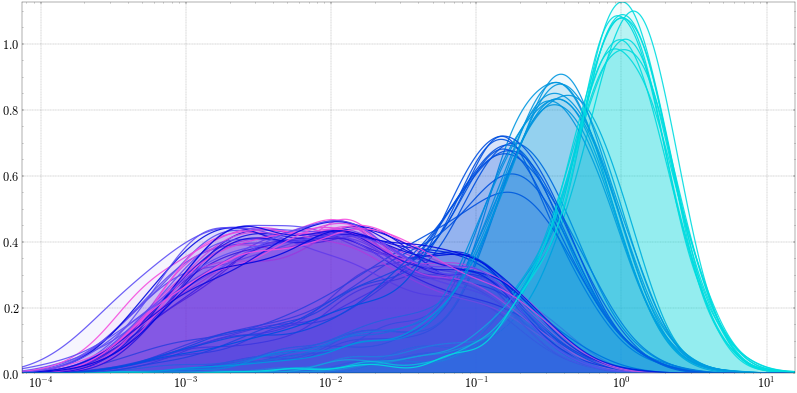

In [18]:
idx = (-1, 2)
idxs = slice(3, None)
plot = plots.PlotDistribution(
    data['nets'][*idx, 0].transforms['targets'](distributions[*idx, :, idxs].reshape(-1), back=True),
    log=True,
    y_axes=True,
    density=True,
    colours=np.tile(colours[idxs], distributions.shape[-2]),
    bins=500,
    alpha_2d=0.05,
    fig_size=(8,4),
)

50%       5%      16%      84%      95%        -        +
BAHAMAS-0w   0.00649  0.00164  0.00262  0.01390  0.02162  0.00387  0.00741
BAHAMAS-0s   0.00938  0.00205  0.00360  0.01650  0.02506  0.00578  0.00712
BAHAMAS-0    0.00938  0.00220  0.00360  0.01912  0.03622  0.00578  0.00974
BAHAMAS-0.1  0.15811  0.08987  0.11489  0.21230  0.26482  0.04322  0.05420
BAHAMAS-0.3  0.35560  0.21230  0.25840  0.47749  0.58117  0.09720  0.12189
BAHAMAS-1    0.99764  0.67345  0.78038  1.27540  1.51466  0.21727  0.27776

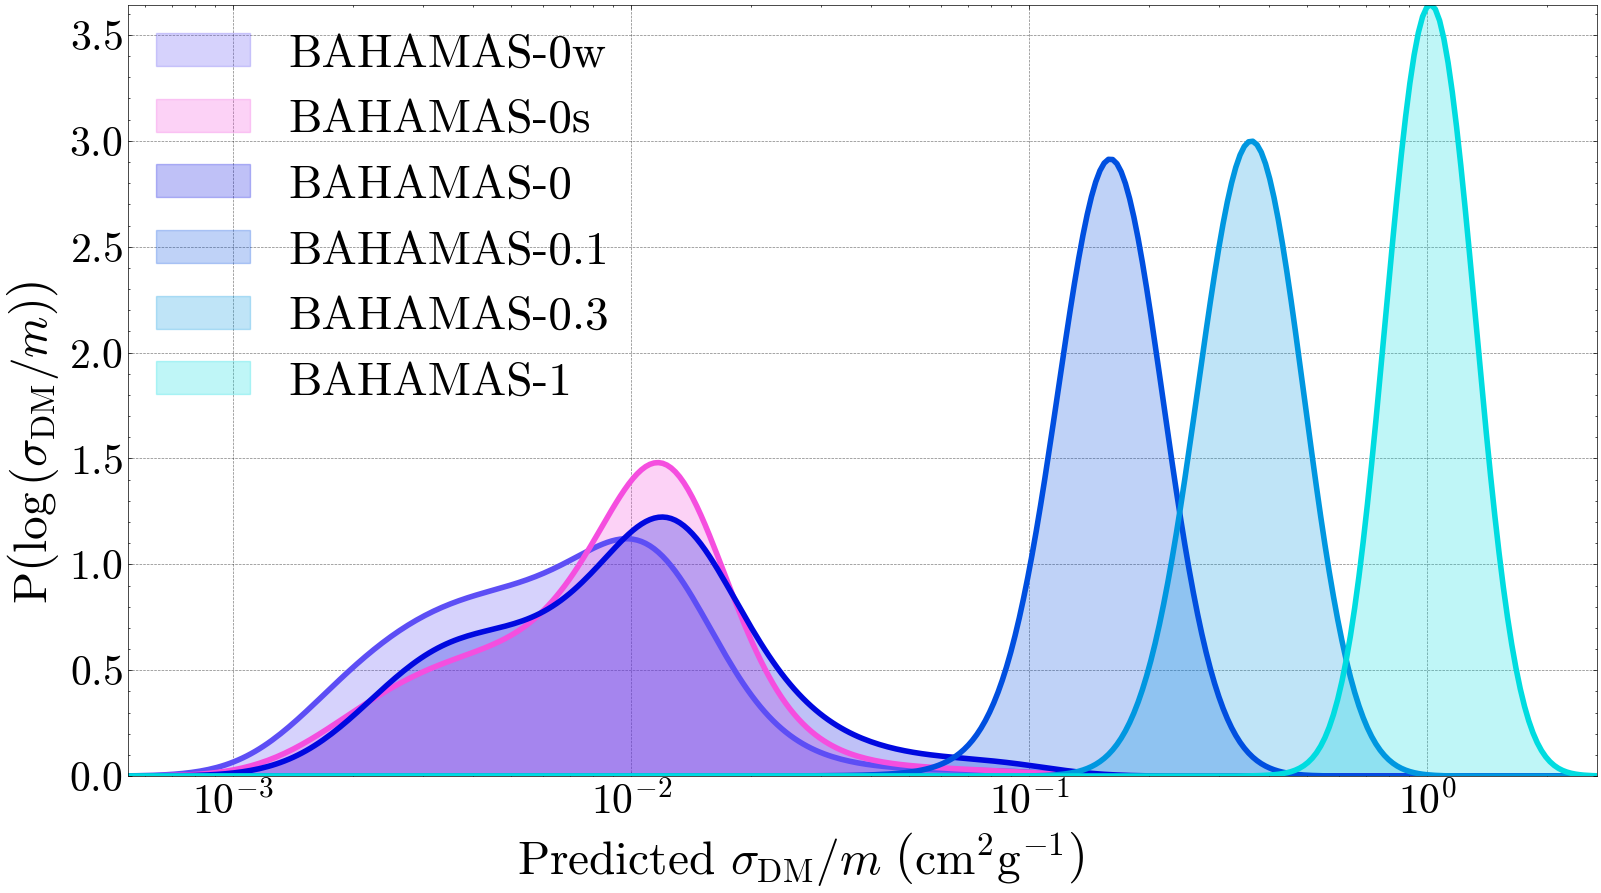

In [19]:
plot2 = plots.PlotPlots(
    grids[*idx],
    probs[*idx, idxs],
    log_x=True,
    error_region=True,
    x_label=r'Predicted $\sigma_{\rm DM}/m\ \left(\rm cm^2g^{-1}\right)$',
    y_label=r'${\rm P}\left(\log{\left(\sigma_{\rm DM}/m\right)}\right)$',
    y_error=np.stack((probs[*idx, idxs], np.zeros_like(probs[*idx, idxs]))).swapaxes(0, 1),
    styles='-',
    labels=labels[idxs],
    colours=colours[idxs],
    axis=True,
    frameon=False,
    loc='upper left',
    cols=1,
    alpha_2d=0.25,
    major=plot_config.MAJOR,
    minor=plot_config.MINOR,
    line_width=4,
)
# merge_plots(plot2, plot)
plot2.axes.set_xlim(np.min(np.array(plot2._data)[(np.array(plot2._y_data) > 1e-3)]), np.max(np.array(plot2._data)[(np.array(plot2._y_data) > 1e-3)]))
plot2.savefig(plots_dir, name='final_reduced_network')
pd.DataFrame(quantiles[:, *idx, idxs].swapaxes(0, 1), index=labels[idxs], columns=[f'{quantile:.0%}' for quantile in list(quantile_values)] + ['-', '+']).round(5)

# Clustering Noise

In [21]:
torch.manual_seed(0)
np.random.seed(0)
dataset = DarkDataset(
    data_dir,
    [
        'bahamas_cdm',
        'bahamas_0.1',
        'bahamas_0.3',
        'bahamas_1',
    ],
    ['noise'],
)
dataset.low_dim = dataset.unique_labels(dataset.low_dim, dataset.extra['sims'])
labels = dataset.extra['names'].iloc[np.unique(dataset.low_dim, return_index=True)[1]].to_numpy()
colours = np.array(['k'] + plot_config.BAHAMAS)
dataset.high_dim.shape

(15400, 3, 100, 100)

In [22]:
idx = (0, 10)
predictions = analysis.gen_predictions(
    config['training']['batch-size'],
    config['training']['validation-fraction'],
    data['nets'][*idx],
    dataset,
)
data_pred, distributions, new_distributions, grids, probs, quantiles = analysis.probs_distributions(
    quantile_values,
    predictions[np.newaxis, np.newaxis],
    data['nets'],
    dataset,
)
quantiles = np.concat((quantiles, [quantiles[0] - quantiles[2], quantiles[3] - quantiles[0]]), axis=0)
distributions.shape, new_distributions.shape, grids.shape, probs.shape, quantiles.shape

Loader Dataset Lengths: [12320, 3080]
Prediction time: 1.048e+00 s
Prediction time: 6.693e-01 s
Prediction time: 6.689e-01 s
Prediction time: 6.716e-01 s
Prediction time: 6.710e-01 s
Prediction time: 6.601e-01 s
Prediction time: 6.577e-01 s
Prediction time: 6.619e-01 s
Prediction time: 6.616e-01 s
Prediction time: 6.604e-01 s


((1, 1, 10, 5), (1, 1, 5, 500), (1, 1, 500), (1, 1, 5, 500), (7, 1, 1, 5))

50%     5%    16%    84%    95%      -      +
Noise        0.021  0.016  0.018  0.023  0.025  0.003  0.003
BAHAMAS-0    0.002  0.000  0.001  0.003  0.005  0.001  0.002
BAHAMAS-0.1  0.092  0.021  0.044  0.168  0.231  0.048  0.076
BAHAMAS-0.3  0.446  0.206  0.282  0.667  0.839  0.164  0.221
BAHAMAS-1    1.366  0.815  1.026  1.820  2.162  0.341  0.454

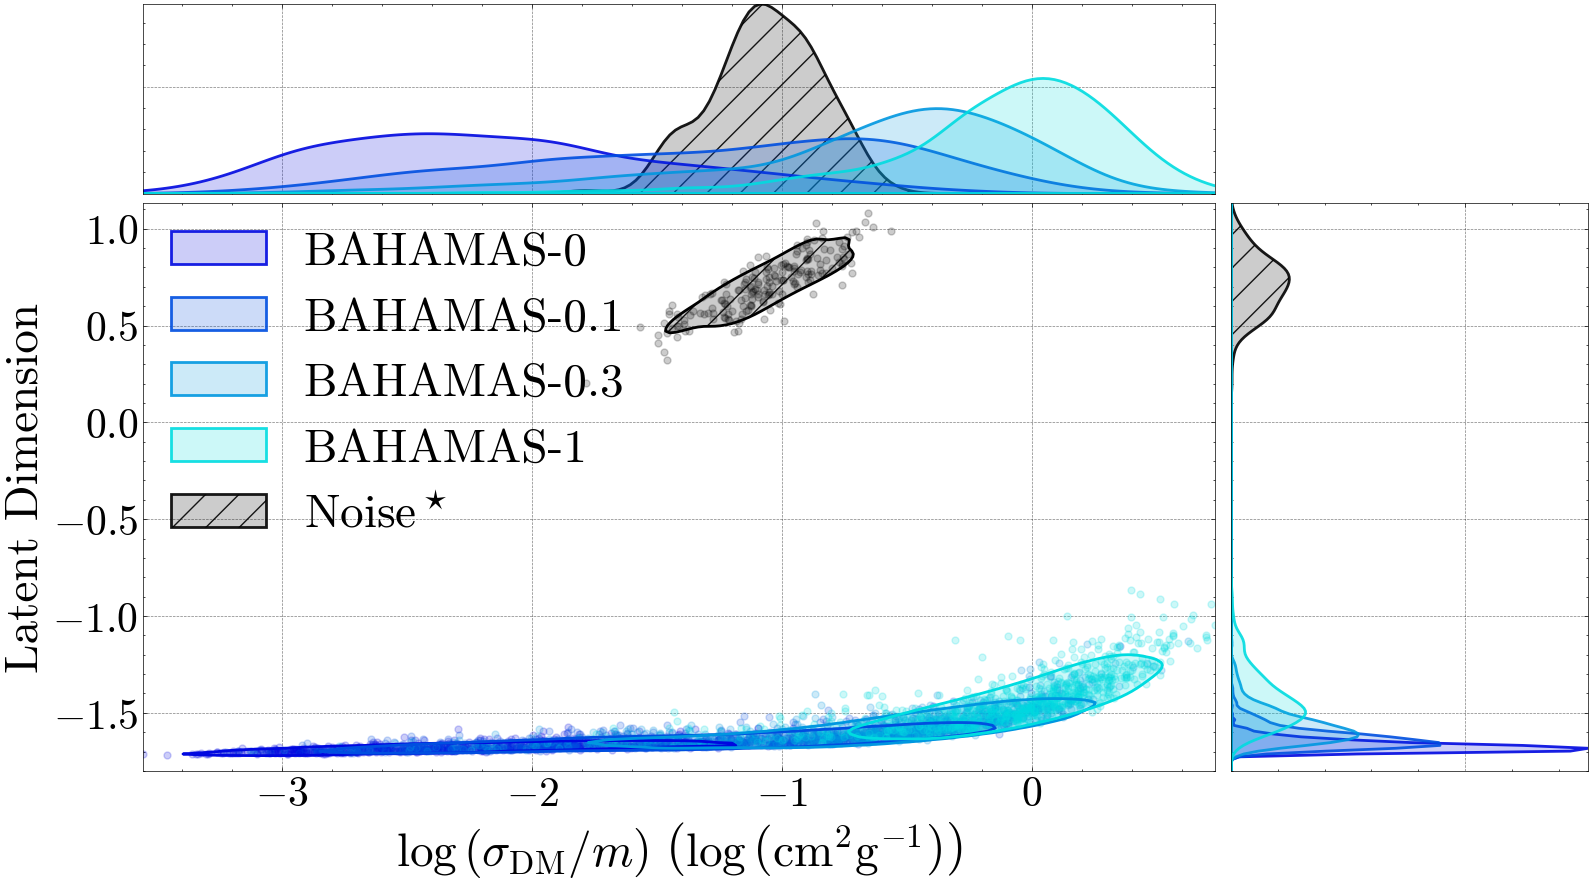

In [23]:
sub_idx = (0, 0, 0)
new_labels = labels.copy().astype(object)
new_labels[colours == 'k'] = new_labels[colours == 'k'] +  rf'$^\star$'

plot = plots.PlotClusters(
    np.concat((
        data['nets'][*idx, 0].transforms['targets'][-1](data_pred['latent'][*sub_idx, :, :1], back=True),
        data_pred['latent'][*sub_idx, :, 1:],
    ), axis=-1)[:, [0, 4]],
    data_pred['targets'][*sub_idx],
    # norm=True,
    density=True,
    labels=new_labels,
    colours=colours,
    x_label=[r'$\log{\left(\sigma_{\rm DM}/m\right)}\ \left(\log{\left(\rm cm^2 g^{-1}\right)}\right)$', ''],
    y_label=['', 'Latent Dimension'],
    hatches=['/'] + [''] * (len(labels) - 1),
    major=plot_config.MAJOR,
    minor=plot_config.MINOR,
    alpha_marker=0.2,
    marker_size=100,
    alpha_2d=0.2,
)
plot.axes[0, 0].tick_params(labelleft=False, left=False)
plot.axes[1, 1].tick_params(labelbottom=False, bottom=False)
plot.legend_axis = plot.axes[1, 0]
plot.create_legend(axis=True, cols=1, loc='upper left', label_permute=[1, 2, 3, 4, 0], frameon=False)
plot.savefig(plots_dir, name='clustering_noise_pca')
pd.DataFrame(
    quantiles[:, *sub_idx[:2]].swapaxes(0, 1),
    index=labels,
    columns=[f'{quantile:.0%}' for quantile in quantile_values] + ['-', '+'],
).round(3)

In [24]:
sub_quantiles = []
sub_grid = np.linspace(np.min(distributions[*sub_idx, 0]), np.max(distributions[*sub_idx, 0]), 500)
kernel = stats.gaussian_kde(distributions[*sub_idx, 0])
sub_cumsums = kernel(sub_grid)
sub_cumsums = np.cumsum(sub_cumsums / np.trapezoid(sub_cumsums, np.log10(sub_grid)))

for i, percentile in enumerate(quantile_values):
    sub_quantiles.append(sub_grid[np.argmin(np.abs(sub_cumsums - percentile))])

sub_quantiles.append(sub_quantiles[0] - sub_quantiles[2])
sub_quantiles.append(sub_quantiles[3] - sub_quantiles[0])
sub_quantiles = np.array(sub_quantiles)
np.round(sub_quantiles, 4)

array([0.1175, 0.1077, 0.1102, 0.1249, 0.1273, 0.0073, 0.0073],
      dtype=float32)

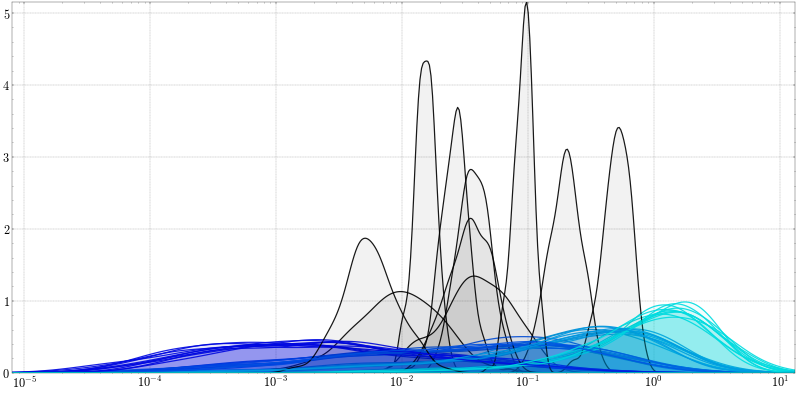

In [25]:
idx = (-1, 0)
plot = plots.PlotDistribution(
    data['nets'][*idx, 0].transforms['targets'](distributions[*sub_idx[:2]].reshape(-1), back=True),
    log=True,
    y_axes=True,
    density=True,
    colours=np.tile(np.array(colours), distributions.shape[-2]).tolist(),
    bins=500,
    alpha_2d=0.05,
    fig_size=(8, 4),
)

50%     5%    16%    84%    95%      -      +
Noise        0.021  0.016  0.018  0.023  0.025  0.003  0.003
BAHAMAS-0    0.002  0.000  0.001  0.003  0.005  0.001  0.002
BAHAMAS-0.1  0.092  0.021  0.044  0.168  0.231  0.048  0.076
BAHAMAS-0.3  0.446  0.206  0.282  0.667  0.839  0.164  0.221
BAHAMAS-1    1.366  0.815  1.026  1.820  2.162  0.341  0.454

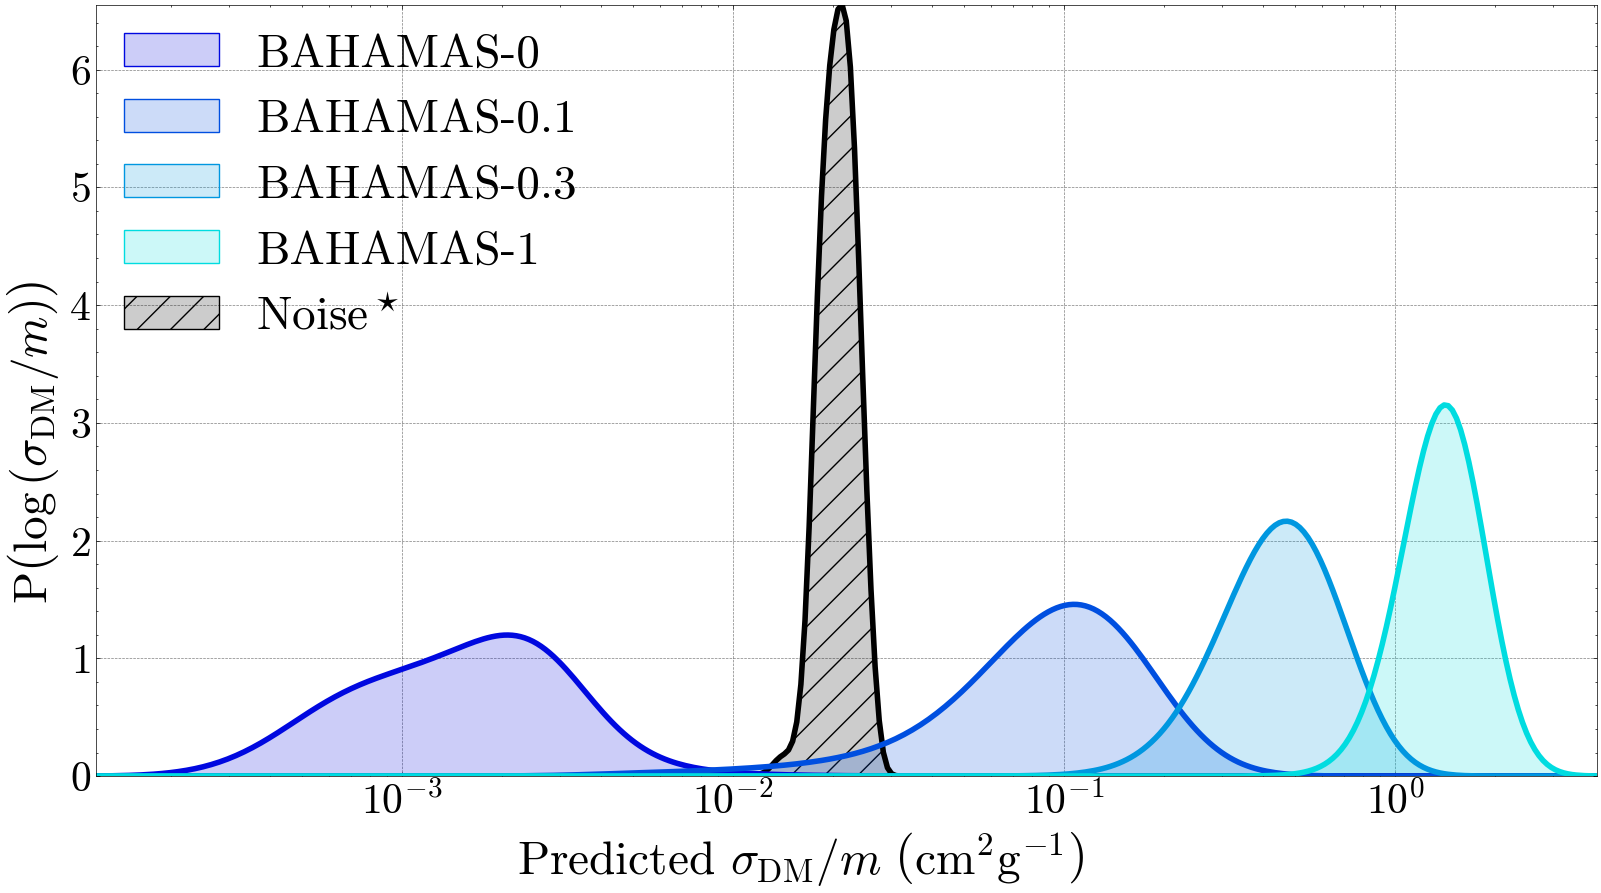

In [26]:
styles = np.array(['-'] * len(labels), dtype=object)
styles[colours == 'k'] = '--'
hatches = np.array([''] * len(labels), dtype=object)
hatches[colours == 'k'] = '/'
new_labels = labels.copy().astype(object)
new_labels[colours == 'k'] = new_labels[colours == 'k'] + rf'$^\star$'
plot2 = plots.PlotPlots(
    grids[*sub_idx[:2]],
    probs[*sub_idx[:2]],
    log_x=True,
    x_label=r'Predicted $\sigma_{\rm DM}/m\ \left(\rm cm^2g^{-1}\right)$',
    y_label=r'${\rm P}\left(\log{\left(\sigma_{\rm DM}/m\right)}\right)$',
    labels=new_labels,
    colours=colours,
    styles='-',
    axis=True,
    frameon=False,
    loc='upper left',
    label_permute=[1, 2, 3, 4, 0],
    cols=1,
    alpha_2d=0.2,
    major=plot_config.MAJOR,
    minor=plot_config.MINOR,
    line_width=4,
)
for label, colour, hatch, y_datum in zip(new_labels, colours, hatches, probs[*sub_idx[:2]]):
    plot2.plots[plot2.axes].append(plot2.axes.fill_between(
        grids[*sub_idx[:2]],
        y_datum,
        hatch=hatch,
        label=label,
        facecolor=(colour, plot2._alpha_2d),
        edgecolors=(colour, plot2._alpha_line),
    ))
plot2.create_legend(**plot2._legend_kwargs)
plot2.axes.set_xlim(np.min(np.array(plot2._data)[(np.array(plot2._y_data) > 1e-3)]), np.max(np.array(plot2._data)[(np.array(plot2._y_data) > 1e-3)]))
# merge_plots(plot2, plot)
plot2.savefig(plots_dir, name='regression_noise')
pd.DataFrame(
    quantiles[:, *sub_idx[:2]].swapaxes(0, 1),
    index=labels,
    columns=[f'{quantile:.0%}' for quantile in quantile_values] + ['-', '+'],
).round(3)

In [27]:
proj_vecs = np.empty(data_pred['latent'].shape[:-2], dtype=object)

for shape in np.ndindex(data_pred['latent'].shape[:-2]):
    proj_vecs[*shape] = analysis.proj_all_inter_1d(data_pred['latent'][..., 1:][*shape], data_pred['targets'][*shape])

proj_vecs = np.array(proj_vecs.tolist(), dtype=object)
proj_vecs = proj_vecs.swapaxes(-2, -1)

bins = 500
cdfs = np.empty((*proj_vecs.shape, bins), dtype=float)

for shape in np.ndindex(proj_vecs.shape[:-1]):
    grid = np.mgrid[np.min(np.concat(proj_vecs[*shape])):np.max(np.concat(proj_vecs[*shape])):bins * 1j]
    cdfs[*shape] = [
        analysis.distribution_func(proj_vecs[*shape, 0], norm=True, cumulative=True, grid=grid)[1],
        analysis.distribution_func(proj_vecs[*shape, 1], norm=True, cumulative=True, grid=grid)[1],
    ]

emds = np.mean(np.subtract(cdfs[..., 0, :], cdfs[..., 1, :]), axis=-1)
overlaps = np.empty(proj_vecs.shape[:-1], dtype=float)

for shape in np.ndindex(overlaps.shape):
    overlaps[*shape] = overlap(*proj_vecs[*shape])

emd_means = np.mean(emds, axis=-3)
emd_stes = np.std(emds, axis=-3, ddof=1) / np.sqrt(emds.shape[-3])
overlap_means = np.mean(overlaps, axis=-3)
overlap_stes = np.std(overlaps, axis=-3, ddof=1) / np.sqrt(overlaps.shape[-3])
proj_vecs.shape, emd_means.shape

((1, 1, 10, 5, 4, 2), (1, 1, 5, 4))

BAHAMAS-0  BAHAMAS-0.1  BAHAMAS-0.3  BAHAMAS-1
EMD Mean          0.874        0.867        0.849      0.832
EMD STE           0.009        0.008        0.007      0.010
Overlap Mean      0.000        0.000        0.000      0.000
Overlap STE       0.000        0.000        0.000      0.000

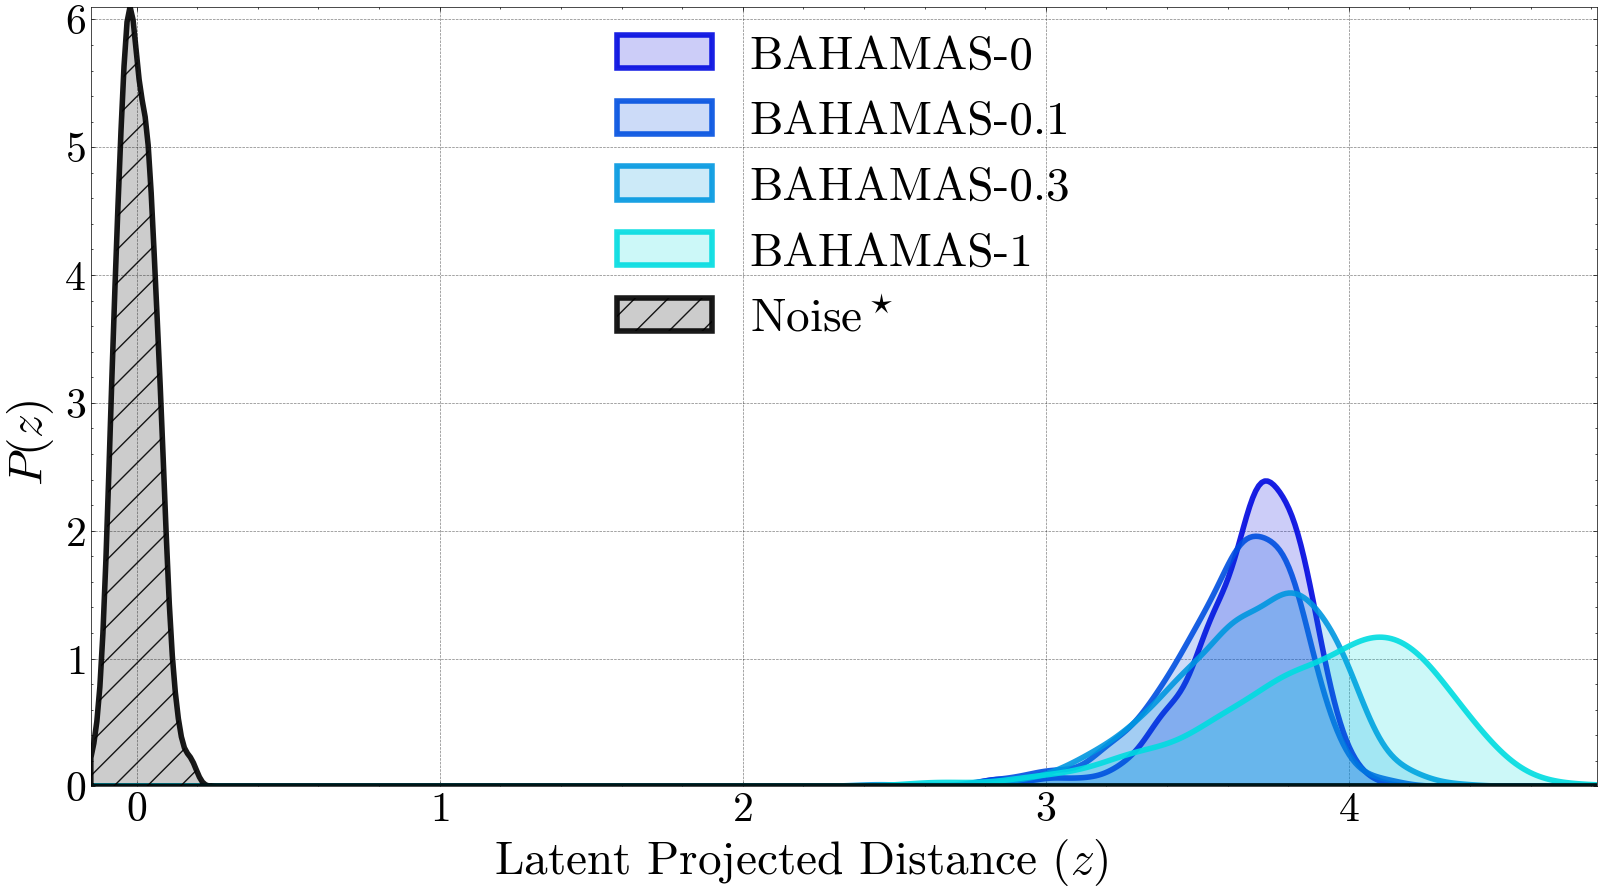

In [28]:
mmd_idx = 0

plot = plots.PlotDistribution(
    [*proj_vecs[*sub_idx, mmd_idx, :, 1], proj_vecs[*sub_idx, mmd_idx, 3, 0]],
    density=True,
    # norm=True,
    y_axes=True,
    bins=500,
    x_labels='Latent Projected Distance $(z)$',
    y_labels='$P(z)$',
    colours=np.append(colours[np.arange(len(colours)) != mmd_idx], colours[mmd_idx]),
    labels=np.append(new_labels[np.arange(len(labels)) != mmd_idx], new_labels[mmd_idx]),
    hatches=[''] * (len(labels) - 1) + ['/'],
    axis=True,
    frameon=False,
    cols=1,
    line_width=4,
    alpha_2d=0.2,
    major=plot_config.MAJOR,
    minor=plot_config.MINOR,
    loc='upper center',
)
plot.savefig(plots_dir, name='clustering_noise_mmd')
pd.DataFrame(
    np.stack((emd_means[0, 0, mmd_idx], emd_stes[0, 0, mmd_idx], overlap_means[0, 0, mmd_idx], overlap_stes[0, 0, mmd_idx])),
    columns=labels[np.arange(len(labels)) != mmd_idx],
    index=['EMD Mean', 'EMD STE', 'Overlap Mean', 'Overlap STE'],
).round(3)

# Regression with Noise

In [4]:
torch.manual_seed(0)
np.random.seed(0)
dataset = DarkDataset(
    data_dir,
    [
        'bahamas_cdm',
        'bahamas_0.1',
        'bahamas_0.3',
        'bahamas_1',
    ],
    ['noise'],
)
dataset.low_dim = dataset.unique_labels(dataset.low_dim, dataset.extra['sims'])
labels = dataset.extra['names'].iloc[np.unique(dataset.low_dim, return_index=True)[1]].to_numpy()
colours = np.array(['k'] + plot_config.BAHAMAS)
dataset.high_dim.shape

(15400, 3, 100, 100)

In [6]:
batch_num = 29
data = analysis.batch_train_summary(batch_num, data_dir, prefix='batch_train')

if isinstance(data['nets'].flatten()[0], str):
    data['nets'] = data['nets'].astype(object)
    for shape in np.ndindex(data['nets'].shape):
        data['nets'][*shape] = torch.load(data['nets'][*shape], weights_only=False, map_location='cpu')

data['nets'].shape

/home/ethan_tregidga/PycharmProjects/Bayesian-DARKSKIES-Remote/venv/lib/python3.12/site-packages/netloader/transforms.py:532: DeprecationWarning: Index transform is saved in old non-weights safe format and is deprecated, please resave the transform in the new format using net.save()
  self.transforms[-1].__setstate__(transform)
/home/ethan_tregidga/PycharmProjects/Bayesian-DARKSKIES-Remote/venv/lib/python3.12/site-packages/torch/serialization.py:2122: DeprecationWarning: Encoder is saved in old non-weights safe format and is deprecated, please resave the network in the new format using net.save()
  result = unpickler.load()


(1, 1, 10)

In [7]:
with open(os.path.join(data_dir, f'temp_batch_predictions_{batch_num}.pkl'), 'rb') as file:
    predictions = pickle.load(file)

In [ ]:
predictions = analysis.gen_predictions(
    config['training']['batch-size'],
    config['training']['validation-fractions'],
    data['nets'],
    dataset,
)

In [110]:
with open(os.path.join(data_dir, f'temp_batch_predictions_{batch_num}.pkl'), 'wb') as file:
    pickle.dump(predictions, file)

In [20]:
for shape in np.ndindex(predictions.shape):
    predictions[*shape]['latent'] = data['nets'][*shape].transforms['targets'][1:](predictions[*shape]['preds'])

In [21]:
data_pred, distributions, new_distributions, grids, probs, quantiles = analysis.probs_distributions(
    quantile_values,
    predictions,
    data['nets'],
    dataset,
)
quantiles = np.concat((quantiles, [quantiles[0] - quantiles[2], quantiles[3] - quantiles[0]]), axis=0)
distributions.shape, new_distributions.shape, grids.shape, probs.shape, quantiles.shape

((1, 1, 10, 5), (1, 1, 5, 500), (1, 1, 500), (1, 1, 5, 500), (7, 1, 1, 5))

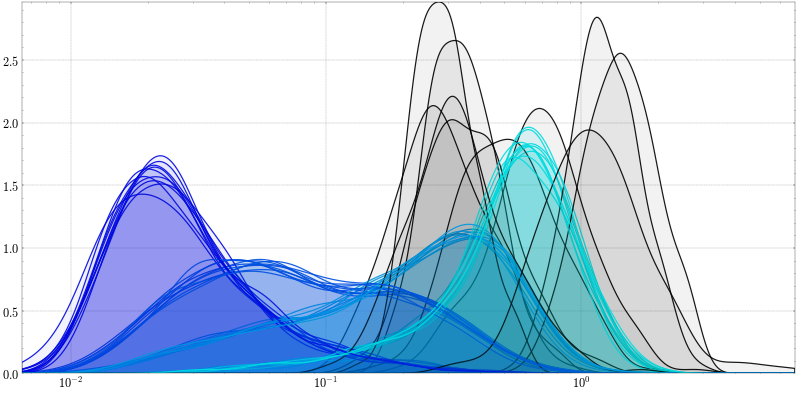

In [22]:
idx = (-1, 0)
plot = plots.PlotDistribution(
    data['nets'][*idx, 0].transforms['targets'](distributions[*idx].reshape(-1), back=True),
    log=True,
    y_axes=True,
    density=True,
    colours=np.tile(np.array(colours), distributions.shape[-2]).tolist(),
    bins=500,
    alpha_2d=0.05,
    fig_size=(8, 4),
)

50%     5%    16%    84%    95%      -      +
Noise        0.595  0.517  0.547  0.647  0.684  0.048  0.052
BAHAMAS-0    0.021  0.016  0.018  0.025  0.028  0.003  0.004
BAHAMAS-0.1  0.052  0.032  0.038  0.074  0.123  0.014  0.022
BAHAMAS-0.3  0.350  0.233  0.280  0.419  0.469  0.070  0.070
BAHAMAS-1    0.612  0.489  0.532  0.694  0.765  0.080  0.082

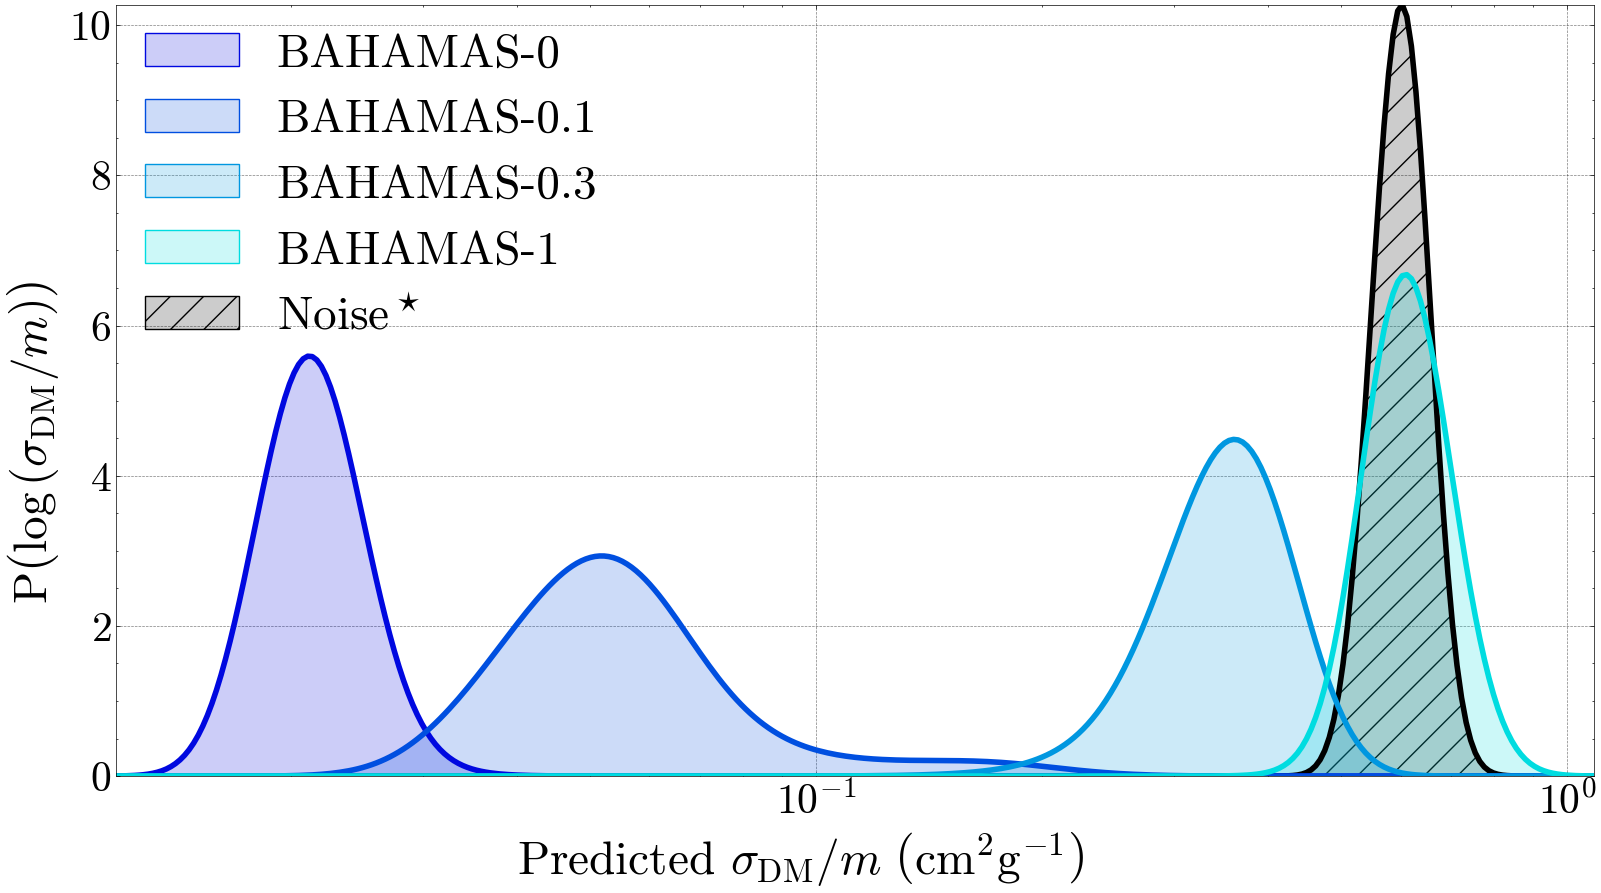

In [23]:
styles = np.array(['-'] * len(labels), dtype=object)
styles[colours == 'k'] = '--'
hatches = np.array([''] * len(labels), dtype=object)
hatches[colours == 'k'] = '/'
new_labels = labels.copy().astype(object)
new_labels[colours == 'k'] = new_labels[colours == 'k'] + rf'$^\star$'
plot2 = plots.PlotPlots(
    grids[*idx],
    probs[*idx],
    log_x=True,
    x_label=r'Predicted $\sigma_{\rm DM}/m\ \left(\rm cm^2g^{-1}\right)$',
    y_label=r'${\rm P}\left(\log{\left(\sigma_{\rm DM}/m\right)}\right)$',
    labels=new_labels,
    colours=colours,
    styles='-',
    axis=True,
    frameon=False,
    loc='upper left',
    label_permute=[1, 2, 3, 4, 0],
    cols=1,
    alpha_2d=0.2,
    major=plot_config.MAJOR,
    minor=plot_config.MINOR,
    line_width=4,
)
for label, colour, hatch, y_datum in zip(new_labels, colours, hatches, probs[*idx]):
    plot2.plots[plot2.axes].append(plot2.axes.fill_between(
        grids[*idx],
        y_datum,
        hatch=hatch,
        label=label,
        facecolor=(colour, plot2._alpha_2d),
        edgecolors=(colour, plot2._alpha_line),
    ))
plot2.create_legend(**plot2._legend_kwargs)
plot2.axes.set_xlim(np.min(np.array(plot2._data)[(np.array(plot2._y_data) > 1e-3)]), np.max(np.array(plot2._data)[(np.array(plot2._y_data) > 1e-3)]))
# merge_plots(plot2, plot)
plot2.savefig(plots_dir, name='regression_noise')
pd.DataFrame(
    quantiles[:, *idx].swapaxes(0, 1),
    index=labels,
    columns=[f'{quantile:.0%}' for quantile in quantile_values] + ['-', '+'],
).round(3)

# BAHAMAS AGN with X-Rays Latent Space

In [4]:
torch.manual_seed(0)
np.random.seed(0)
dataset = DarkDataset(
    data_dir,
    [
        'bahamas_cdm',
        'bahamas_cdm_low',
        'bahamas_cdm_hi',
        'bahamas_0.1',
        'bahamas_0.3',
        'bahamas_1',
        # 'darkskies_cdm',
        # 'darkskies_0.1',
        # 'darkskies_0.2',
    ],
    [],
)
net = nets.load_net('46_1', states_dir, 'network_v8')
# net = nets.load_net('49_1', '../model_states/', 'network_v8', weights_only=False)
dataset.low_dim = dataset.unique_labels(dataset.low_dim, dataset.extra['sims'])
net.transforms['inputs'][1]._shape = dataset.high_dim.shape[1:]
dataset.high_dim = net.transforms['inputs'](dataset.high_dim)
dataset.low_dim = net.transforms['targets'](dataset.low_dim)
labels = dataset.extra['names'].iloc[np.unique(dataset.low_dim, return_index=True)[1]].to_numpy()
colours = np.array(plot_config.BAHAMAS_AGN + plot_config.BAHAMAS)
loaders = loader_init(dataset, idxs=net.idxs)
net.to('cuda')
data = net.predict(loaders[1])
net.to('cpu')

data['targets'] = data['targets'].flatten()
dataset.high_dim.shape

/home/ethan_tregidga/PycharmProjects/Bayesian-DARKSKIES-Remote/venv/lib/python3.12/site-packages/netloader/transforms.py:532: DeprecationWarning: Index transform is saved in old non-weights safe format and is deprecated, please resave the transform in the new format using net.save()
  self.transforms[-1].__setstate__(transform)


Prediction time: 2.165e+00 s


torch.Size([21600, 2, 100, 100])

In [5]:
pca = PCA(n_components=4).fit(data['latent'])
pca_transform = pca.transform(data['latent'])
pca_transform[:, 0] *= -1
pca_transform.shape

(4320, 4)

In [29]:
np.cumsum(pca.explained_variance_ratio_), pca.explained_variance_ratio_

(array([0.4669187 , 0.747216  , 0.8815927 , 0.96427476], dtype=float32),
 array([0.4669187 , 0.28029728, 0.13437669, 0.08268208], dtype=float32))

In [41]:
preds = []
grid = net.transforms['targets'](np.linspace(np.min(data['latent'][:, 0]), np.max(data['latent'][:, 0]), 100), back=True)

for target in np.unique(data['targets']):
    idxs = data['targets'] == target
    preds.append(stats.gaussian_kde(data['latent'][idxs, 0]))

for label, pred in zip(labels, preds):
    cdf = pred(net.transforms['targets'][1:](grid))
    cdf = np.cumsum(cdf) / np.sum(cdf)
    print(f'{label.replace(r'$\textsc{', '').replace('}$', ''):<15}:\t'
          f'{grid[np.argmin(np.abs(cdf - 0.5))] * 1000:.5f} - '
          f'{(grid[np.argmin(np.abs(cdf - 0.5))] - grid[np.argmin(np.abs(cdf - 0.16))]) * 1000:.5f} + '
          f'{(grid[np.argmin(np.abs(cdf - 0.84))] - grid[np.argmin(np.abs(cdf - 0.5))]) * 1000:.5f}')

BAHAMAS-0w     :	1.45785 - 1.23330 + 14.94991
BAHAMAS-0s     :	68.59504 - 50.27877 + 251.53347
BAHAMAS-0      :	10.56567 - 9.10782 + 44.47918
BAHAMAS-0.1    :	76.57388 - 60.16612 + 180.31678
BAHAMAS-0.3    :	256.89066 - 212.71929 + 515.12807
BAHAMAS-1      :	962.06436 - 563.13117 + 899.72933


In [42]:
preds = []
grid = np.linspace(np.min(pca_transform[:, 1]), np.max(pca_transform[:, 1]), 100)

for target in np.unique(data['targets']):
    idxs = data['targets'] == target
    preds.append(stats.gaussian_kde(pca_transform[idxs, 1]))

for label, pred in zip(labels, preds):
    cdf = pred(grid)
    cdf = np.cumsum(cdf) / np.sum(cdf)
    print(f'{label.replace(r'$\textsc{', '').replace('}$', ''):<15}:\t'
          f'{grid[np.argmin(np.abs(cdf - 0.5))]:.5f} - '
          f'{grid[np.argmin(np.abs(cdf - 0.5))] - grid[np.argmin(np.abs(cdf - 0.16))]:.5f} + '
          f'{grid[np.argmin(np.abs(cdf - 0.84))] - grid[np.argmin(np.abs(cdf - 0.5))]:.5f}')

BAHAMAS-0w     :	-1.01257 - 0.67744 + 0.94841
BAHAMAS-0s     :	1.15522 - 0.49679 + 0.40646
BAHAMAS-0      :	0.07133 - 0.85809 + 0.81292
BAHAMAS-0.1    :	-0.01900 - 0.63227 + 0.81292
BAHAMAS-0.3    :	-0.15449 - 0.67744 + 0.67744
BAHAMAS-1      :	-0.28997 - 0.45162 + 0.45162


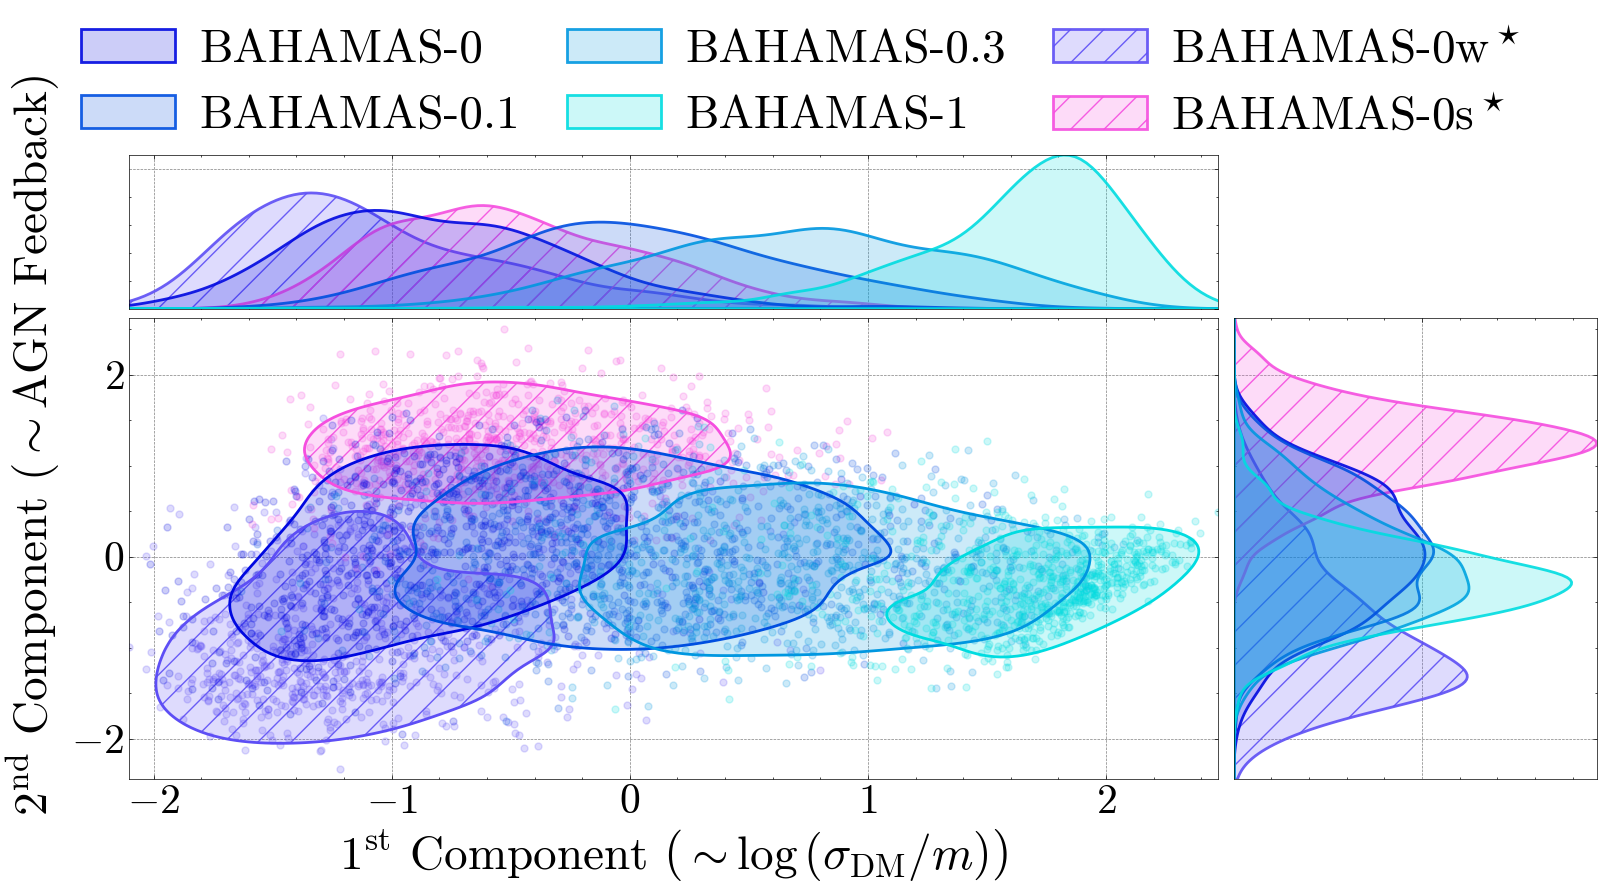

In [28]:
new_labels = labels.copy().astype(object)
new_labels[:2] = new_labels[:2] + rf'$^\star$'
idxs = np.random.choice(range(len(pca_transform)), size=1000, replace=False)
plot = plots.PlotClusters(
    # np.concat((
    #     net.transforms['targets'][-1](data['latent'][:, :1], back=True),
    #     data['latent'][:, 1:],
    # ), axis=-1)[:, :2],
    pca_transform[:, :2],
    data['targets'].flatten(),
    # norm=True,
    density=True,
    labels=new_labels,
    colours=colours,
    hatches=['/'] * 2 + [''] * (len(labels) - 2),
    x_label=[r'$1^{\rm st}$ Component $\left(\sim\log{\left(\sigma_{\rm DM}/m\right)}\right)$', ''],
    y_label=r'$2^{\rm nd}$ Component ($\sim$AGN Feedback)',
    major=plot_config.MAJOR,
    minor=plot_config.MINOR,
    alpha_marker=0.2,
    marker_size=100,
    alpha_2d=0.2,
    columnspacing=1,
    handletextpad=0.5,
    label_permute=[2, 3, 4, 5, 0, 1],
    frameon=False,
)
plot.axes[0, 0].tick_params(labelleft=False, left=False)
plot.axes[1, 1].tick_params(labelbottom=False, bottom=False)
plot.legend_axis = plot.axes[1, 0]
# plot.create_legend(axis=True, cols=1, loc='lower right', frameon=False)
plot.savefig(plots_dir, name='bahamas_agn_pca')

# BAHAMAS + DARKSKIES Latent Space

In [44]:
torch.manual_seed(0)
np.random.seed(0)
dataset = DarkDataset(
    data_dir,
    [
        'bahamas_cdm',
        'bahamas_cdm_low',
        'bahamas_cdm_hi',
        'bahamas_0.1',
        'bahamas_0.3',
        'bahamas_1',
        'darkskies_cdm',
        'darkskies_0.1',
        'darkskies_0.2',
    ],
    [],
)
# net = nets.load_net('46_1', '../model_states/', 'network_v8', weights_only=False)
net = nets.load_net('49_1', states_dir, 'network_v8')
dataset.low_dim = dataset.unique_labels(dataset.low_dim, dataset.extra['sims'])
net.transforms['inputs'][1]._shape = dataset.high_dim.shape[1:]
dataset.high_dim = net.transforms['inputs'](dataset.high_dim)
dataset.low_dim = net.transforms['targets'](dataset.low_dim)
labels = dataset.extra['names'].iloc[np.unique(dataset.low_dim, return_index=True)[1]].to_numpy()
# labels = np.array([r'$\textsc{' + label + '}$' if label.lower() != 'noise' else label for label in labels])
colours = np.array(plot_config.FLAMINGO[:1] + plot_config.BAHAMAS_AGN + plot_config.BAHAMAS[:1] + plot_config.FLAMINGO[1:2] + plot_config.BAHAMAS[1:2] + plot_config.FLAMINGO[2:] + plot_config.BAHAMAS[2:])
loaders = loader_init(dataset, idxs=net.idxs)
net.to('cuda')
data = net.predict(loaders[1])
net.to('cpu')

data['targets'] = data['targets'].flatten()
dataset.high_dim.shape

Prediction time: 4.713e-01 s


torch.Size([25200, 2, 100, 100])

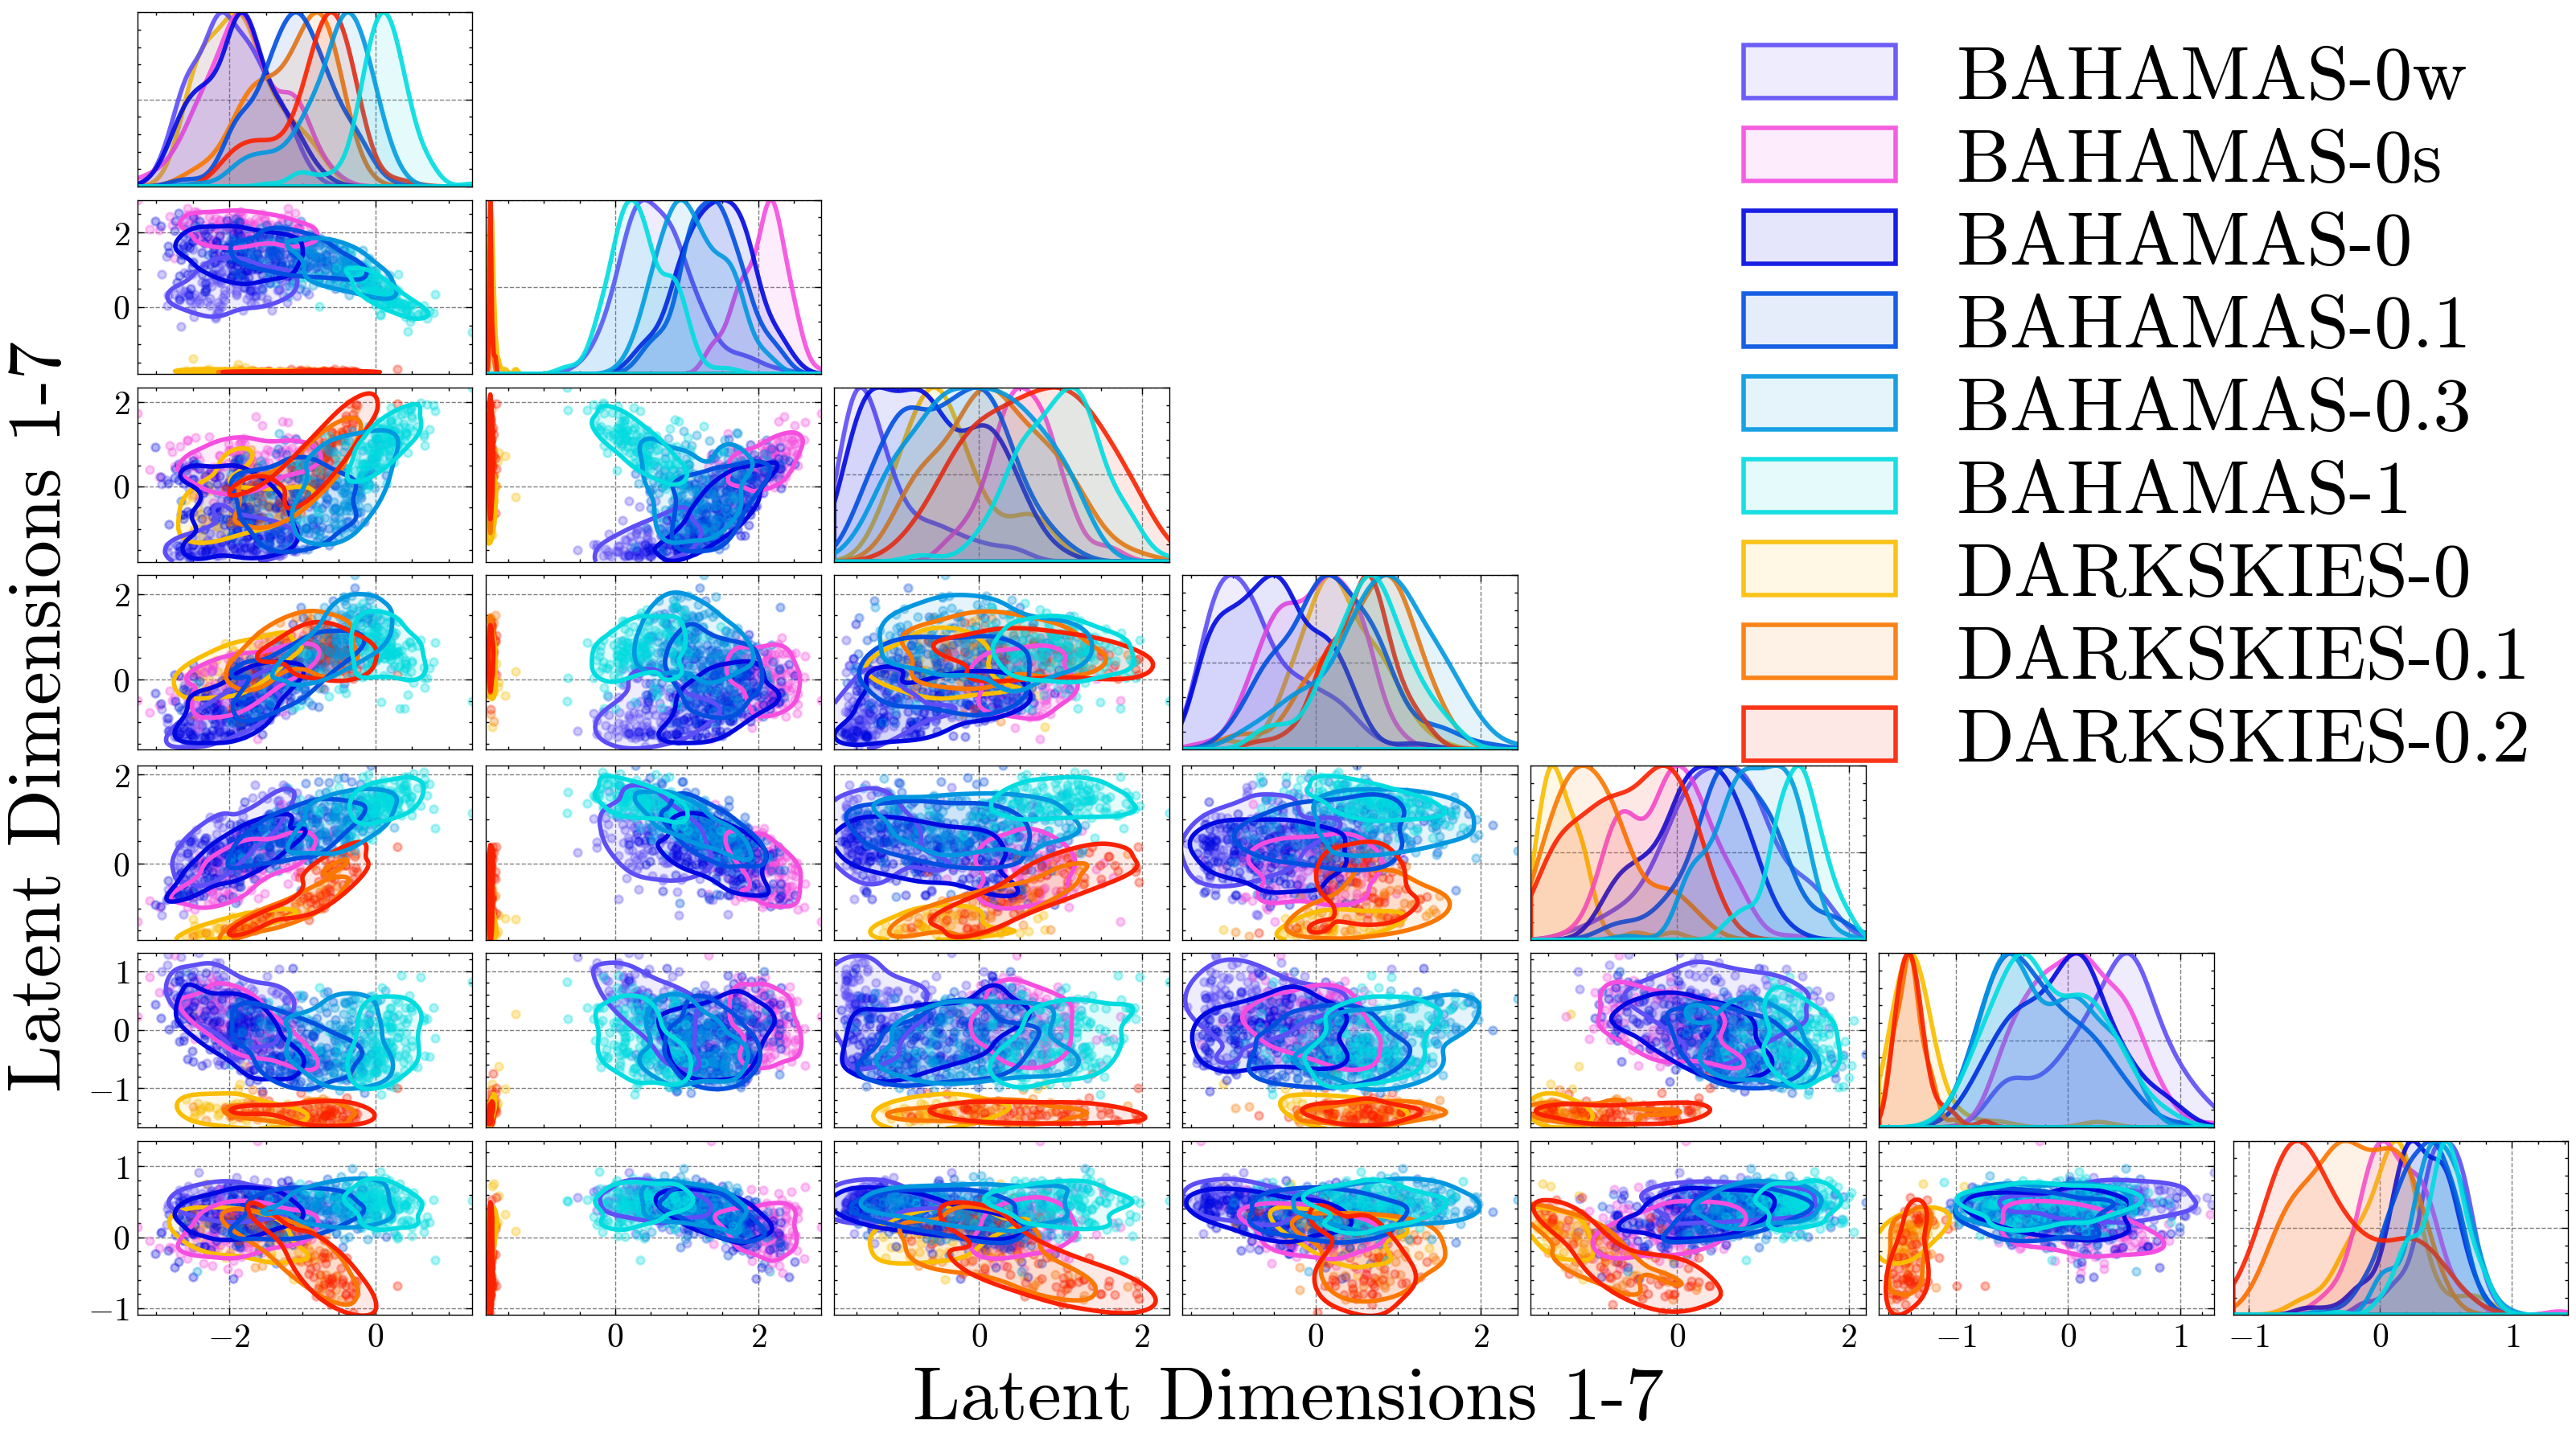

In [45]:
plot = plots.PlotClusters(
    np.concat((
        net.transforms['targets'][-1](data['latent'][:, :1], back=True),
        data['latent'][:, 1:],
    ), axis=-1),
    data['targets'].flatten(),
    norm=True,
    density=True,
    x_label='Latent Dimensions 1-7',
    y_label='Latent Dimensions 1-7',
    labels=labels,
    colours=colours,
    major=plot_config.MAJOR,
    minor=plot_config.MINOR,
    alpha_2d=0.1,
    frameon=False,
    cols=1,
    labelspacing=0.2,
    loc='upper right',
    label_permute=[1, 2, 3, 5, 7, 8, 0, 4, 6],
)
# plots.utils.cast_func('tick_params', plot.axes, kwargs={'labelleft': False, 'left': False, 'labelbottom': False, 'bottom': False})
plots.utils.cast_func('tick_params', plot.axes, kwargs={'labelsize': 15})
plot.axes[0, 0].tick_params(labelleft=False, left=False)
plot.axes[1, 1].tick_params(labelbottom=False, bottom=False)
plot.legend_axis = plot.axes[1, 0]
plot.savefig(plots_dir, name='latent_space')